In [72]:
import json
from thefuzz import fuzz
import matplotlib.pyplot as plt


In [73]:
with open('../../../data/OpenAlex_CEUR.json', 'r', encoding="utf-8") as file:
    OpenAlex_CEUR = json.load(file)

In [74]:
with open('../../../data/SemanticScholar_CEUR.json', 'r', encoding="utf-8") as file:
    Semantic_Scholar_CEUR = json.load(file)

In [75]:
total_document_ids_found = list(set(list(OpenAlex_CEUR.keys()) + list(Semantic_Scholar_CEUR.keys())))

In [76]:
shared_ids_between_sources = list(set(OpenAlex_CEUR.keys()) & set(Semantic_Scholar_CEUR.keys()))

In [77]:
# Combine the citation data from both sources in nested list

merged_citation_data = []
for i in shared_ids_between_sources:
    citation_info = [i]
    try:
        citation_info.append(OpenAlex_CEUR[i]["cited_by_count"])
    except:
        citation_info.append(None)
    try:
        citation_info.append(int(Semantic_Scholar_CEUR[i][0]["citationCount"]))
    except:
        citation_info.append(None)
    merged_citation_data.append(citation_info)

In [78]:
# Calculate the ranks based on the citation data

sorted_data_by_first = sorted(merged_citation_data, key=lambda x: (x[1], x[0]), reverse=True)
rank = 1
for item in sorted_data_by_first:
    item.append(rank)
    rank += 1

sorted_data_by_second = sorted(merged_citation_data, key=lambda x: (x[2], x[0]), reverse=True)
rank = 1
for item in sorted_data_by_second:
    item.append(rank)
    rank += 1

In [79]:
with open('../../../data/OpenAlex_CEUR_citing_doc.json', 'r', encoding="utf-8") as file:
    OpenAlex_CEUR_addition = json.load(file)

In [80]:
with open('../../../data/SemanticScholar_CEUR_additional_metadata.json', 'r', encoding="utf-8") as file:
    Semantic_CEUR_addition = json.load(file)

In [81]:
combined_citation_titles = []
for i in shared_ids_between_sources:
    citation_titles_for_id = [i]
    try:
        citations_oa = []
        for j in OpenAlex_CEUR_addition[i]:
            if j["title"] is not None:
                citations_oa.append(j["title"])
        citation_titles_for_id.append(citations_oa)
    except:
        print("OpenAlex None")
        citation_titles_for_id.append(None)
    try:
        citations_ss = []
        for k in Semantic_CEUR_addition[i]["citations"]:
            if k["title"] is not None:
                #if k["title"] not in citations_ss:
                citations_ss.append(k["title"])
        citation_titles_for_id.append(citations_ss)
    except:
        print("Semantic None")
        print(i)
        citation_titles_for_id.append(None)
    combined_citation_titles.append(citation_titles_for_id)

In [82]:
non_empty_citation_lists = []
for i in combined_citation_titles:
    if len(i[1]) > 0 and len(i[2]) > 0:
        non_empty_citation_lists.append(i)

In [84]:
def count_overlaps(list1, list2):
    count = 0
    for item1 in list1:
        for item2 in list2:
            if fuzz.ratio(item1, item2) > 60:  
                count += 1
                break 
    return count

for inner_list in non_empty_citation_lists:
    overlap_count = count_overlaps(inner_list[1], inner_list[2])
    inner_list.append((overlap_count/(len(inner_list[1]) + len(inner_list[2])))*100)


In [85]:
for i in non_empty_citation_lists:
    i.append(Semantic_Scholar_CEUR[i[0]][0]["citationCount"] - OpenAlex_CEUR[i[0]]["cited_by_count"])
             

In [86]:
x_values = [item[1] for item in merged_citation_data]
y_values = [item[2] for item in merged_citation_data]
x_values_2 = [item[3] for item in merged_citation_data]
y_values_2 = [item[4] for item in merged_citation_data]
x_values_3 = [item[3] for item in merged_citation_data if item[3] <= 100][:100]
y_values_3 = [item[4] for item in merged_citation_data if item[4] <= 100][:100]
x_values_4 = [item[4] for item in non_empty_citation_lists]
y_values_4 = [item[3] for item in non_empty_citation_lists]

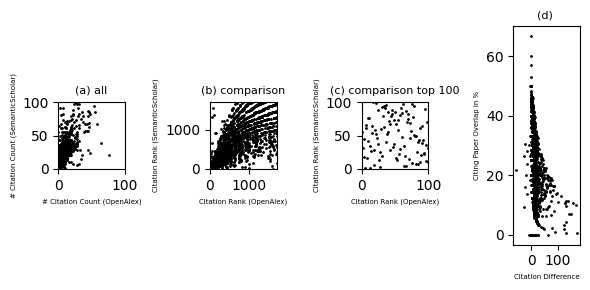

In [90]:
axis_limit_1 = 100 
axis_limit_2 = 1700
axis_limit_3 = 100
fig, axs = plt.subplots(1, 4, figsize=(6, 3))

axs[0].scatter(x_values, y_values, color='black',s=1)
axs[0].set_xlabel('# Citation Count (OpenAlex)', fontsize=5)
axs[0].set_ylabel('# Citation Count (SemanticScholar)', fontsize=5)
axs[0].set_title('(a) all', fontsize=8)
axs[0].set_xlim(0, axis_limit_1)
axs[0].set_ylim(0, axis_limit_1)
#axs[0].grid(True)
axs[0].set_aspect('equal', adjustable='box')

axs[1].scatter(x_values_2, y_values_2, color='black',s=1)
axs[1].set_xlabel('Citation Rank (OpenAlex)', fontsize=5)
axs[1].set_ylabel('Citation Rank (SemanticScholar)', fontsize=5)
axs[1].set_title('(b) comparison', fontsize=8)
axs[1].set_xlim(0, axis_limit_2)
axs[1].set_ylim(0, axis_limit_2)
axs[1].set_aspect('equal', adjustable='box')

axs[2].scatter(x_values_3, y_values_3, color='black',s=1)
axs[2].set_xlabel('Citation Rank (OpenAlex)', fontsize=5)
axs[2].set_ylabel('Citation Rank (SemanticScholar)', fontsize=5)
axs[2].set_title('(c) comparison top 100', fontsize=8)
axs[2].set_xlim(0, axis_limit_3)
axs[2].set_ylim(0, axis_limit_3)
axs[2].set_aspect('equal', adjustable='box')

# Zweiter Scatterplot (Vergleich der Werte 3 und 4)
axs[3].scatter(x_values_4, y_values_4, color='black',s=1)
axs[3].set_xlabel('Citation Difference', fontsize=5)
axs[3].set_ylabel('Citing Paper Overlap in %', fontsize=5)

axs[3].set_title('(d) ', fontsize=8)

plt.tight_layout()
plt.savefig('../../../images/scatterplots_ceur.png', dpi=300)  # Save the figure as a PNG file with 300 dpi

plt.show()